In [1]:
# %load gen_data.py
import math
import numpy as np
import matplotlib.pyplot as plt

# n_range = 40
# n_times = 1000
# n_dims = 3
# np.random.seed(2)
# x = np.empty((n_dims, n_times), 'int64')
# start = np.random.randint(-4*n_range, 4*n_range, n_dims).reshape(n_dims, 1)

# x[:] = start + np.array(range(n_times)) 
# data = np.sin(x / 1.0 / n_range).astype('float64').T
# np.save('./data.npy', data)
data =np.load('./data.npy')

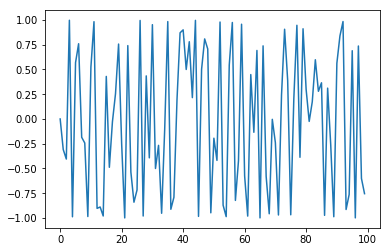

In [2]:
%matplotlib inline
plt.plot(data[:100])

In [1]:
# %load train.py
""" Recurrent Neural Network Time Series.

A Recurrent Neural Network (LSTM) multivariate time series test_preding implementation 
Minimalist example using TensorFlow library.

Links:
    [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
    [dataset Dataset](http://yann.lecun.com/exdb/dataset/).
"""

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy

# Import dataset data
from reader import read_data_sets
from model import RNN, MRNN, TRNN, MTRNN, LSTM, PLSTM
from train_config import *

'''
To test_pred time series using a recurrent neural network, we consider every 
row as a sequence of short time series. Because dataset times series has 9 dim, we will then
handle 9 sequences for every sample.
'''


# Command line arguments 
flags = tf.flags
flags.DEFINE_string("model", "LSTM", "Model used for learning.")
flags.DEFINE_string("data_path", "./lorenz.npy",
          "Where the training/test data is stored.")
flags.DEFINE_string("save_path", "/home/roseyu/log/tensorRNN/",
          "Model output directory.")

flags.DEFINE_bool("use_error_prop", False,
                  "Feed previous output as input in RNN")
flags.DEFINE_integer("hidden_size", 64, "hidden layer size")
flags.DEFINE_float("learning_rate", 1e-2, "learning rate")
flags.DEFINE_integer("num_steps",50,"Training sequence length")
flags.DEFINE_integer("num_test_steps", 50,"Testing sequence length")

FLAGS = flags.FLAGS


# Training Parameters
config = TrainConfig()
# Update config with cmd args
config.use_error_prop = FLAGS.use_error_prop
config.hidden_size = FLAGS.hidden_size
config.learning_rate = FLAGS.learning_rate
config.num_steps = FLAGS.num_steps
config.num_test_steps = FLAGS.num_test_steps

training_steps = 2000#config.training_steps
display_step = 200
num_steps = config.num_steps
num_test_steps = config.num_test_steps
batch_size = config.batch_size

# Construct dataset
dataset, stats = read_data_sets(FLAGS.data_path, num_steps, num_test_steps)

# Network Parameters
num_input = stats['num_input'] # dataset data input (time series dimension: 3)

# Print exp settings
print('='*80) 

print('|data set|', FLAGS.data_path, '|batch size|', batch_size, '|learn rate|', FLAGS.learning_rate)

print('_'*80)
print('|train steps|', num_steps, '|test steps|', num_test_steps, '|error prop|', config.use_error_prop )

print('='*80)

Model = globals()[FLAGS.model]

Model = LSTM
# Construct train model
with tf.name_scope("Train"):
    # tf Graph train input
    X = tf.placeholder("float", [None, num_steps, num_input])
    Y = tf.placeholder("float", [None, num_steps, num_input])
    with tf.variable_scope("Model", reuse=None):
        train_pred = Model(X, True, config)
        # Define train loss 
        train_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(train_pred, Y)))
    tf.summary.scalar('loss', train_loss)

# Construct valid model
with tf.name_scope("Valid"):
    # tf Graph train input
    X_valid = tf.placeholder("float", [None, num_steps, num_input])
    Y_valid = tf.placeholder("float", [None, num_steps, num_input])
    with tf.variable_scope("Model", reuse=True):
        valid_pred = Model(X_valid, True, config)
        # Define train loss 
        valid_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(valid_pred, Y_valid)))
# Construct test model
with tf.name_scope("Test"):
    # tf Graph test input
    X_test = tf.placeholder("float", [None, num_test_steps, num_input])
    Y_test = tf.placeholder("float", [None, num_test_steps, num_input])
    with tf.variable_scope("Model", reuse=True):      
        test_pred = Model(X_test, False, config)
        # Define test loss 
        test_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(test_pred, Y_test)))

# Define optimizer
optimizer = tf.train.RMSPropOptimizer(learning_rate=config.learning_rate)
train_op = optimizer.minimize(train_loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()


# Start training
with tf.Session() as sess:
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.save_path + '/train',sess.graph)
    test_writer = tf.summary.FileWriter(FLAGS.save_path + '/test')

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            summary, tr_loss = sess.run([merged, train_loss], feed_dict={X: batch_x,Y: batch_y})
            train_writer.add_run_metadata(run_metadata, 'step%03d' % step)
            train_writer.add_summary(summary, step)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(tr_loss) )
    print("Optimization Finished!")

    # Calculate accuracy for valid inps
    valid_data = dataset.validation.inps.reshape((-1, num_steps, num_input))
    valid_label = dataset.validation.outs
    va_loss = sess.run(valid_loss, feed_dict={X_valid: valid_data, Y_valid: valid_label})
    print("Validation Loss:", va_loss)

    # Fetch test prediction
    fetches = {
        "true":Y_test,
        "pred":test_pred,
        "loss":test_loss
    }
    # Calculate accuracy for test inps
    test_data = dataset.test.inps.reshape((-1, num_test_steps, num_input))
    test_label = dataset.test.outs
    test_vals = sess.run(fetches, feed_dict={X_test: test_data, Y_test: test_label})
    print("Testing Loss:", test_vals["loss"])

#     # Save the variables to disk.
#     save_path = saver.save(sess, FLAGS.save_path)
#     print("Model saved in file: %s" % save_path)
#     # Save predictions 
#     numpy.save(save_path+"predict.npy", (test_vals["true"], test_vals["pred"]))
#     # Save config file
#     with open(save_path+"config.out", 'w') as f:
#         f.write('num_layers:'+ str(config.num_layers) +'\t'+'hidden_size:'+ str(config.hidden_size)+
#             '\t'+ 'num_steps:'+ str(config.num_steps) +
#             '\t'+ 'learning_rate:'+ str(config.learning_rate)  +'\t'+ 'err_prop:'+ str(config.use_error_prop) + '\n')
#         f.write('train_error:'+ str(tr_loss) + '\t' + 'valid_error:'+ str(va_loss) + 
#                 '\t'+ 'test_error:'+ str(test_vals["loss"]) + '\n')

loading time series ...
input type  <class 'numpy.ndarray'> (1000, 100, 3)
normalize to (0-1)
|data set| ./lorenz.npy |batch size| 128 |learn rate| 0.01
________________________________________________________________________________
|train steps| 50 |test steps| 50 |error prop| False
Creating model input = ground truth each timestep.
Creating model input = ground truth each timestep.
Creating model input = ground truth each timestep.
Step 1, Minibatch Loss= 0.2697
Step 200, Minibatch Loss= 0.2054
Step 400, Minibatch Loss= 0.0901
Step 600, Minibatch Loss= 0.0680
Step 800, Minibatch Loss= 0.0434
Step 1000, Minibatch Loss= 0.0448
Step 1200, Minibatch Loss= 0.0288
Step 1400, Minibatch Loss= 0.0260
Step 1600, Minibatch Loss= 0.0425
Step 1800, Minibatch Loss= 0.0382
Step 2000, Minibatch Loss= 0.0231
Optimization Finished!
Validation Loss: 0.0385546
Testing Loss: 0.0227459


### visualize the predictions (LSTM no error prop)

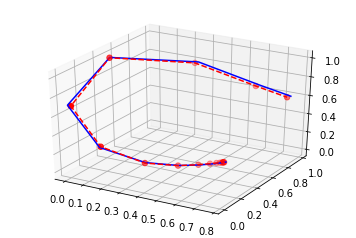

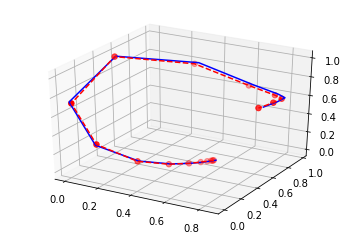

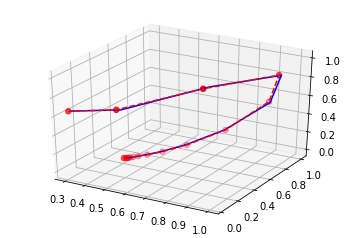

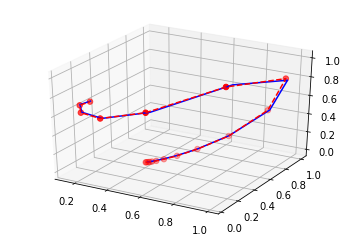

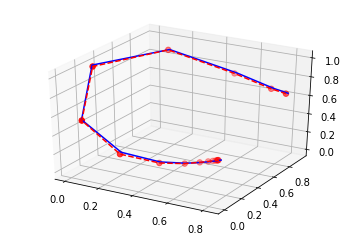

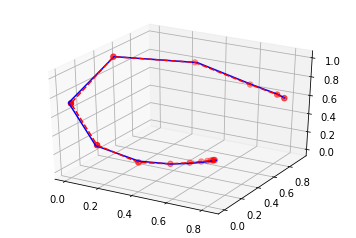

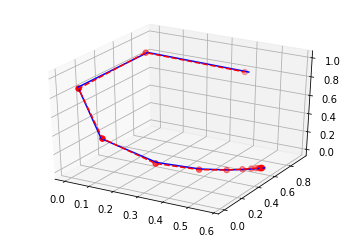

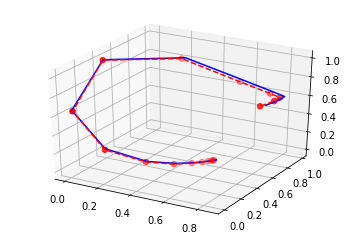

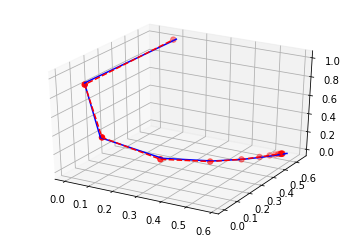

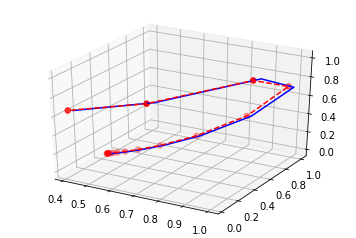

In [4]:
import numpy as np

data_path = "/var/tmp/tensorRNN/log/lorenz//09-27-17-17-08-50/LSTM/"
true, pred = np.load(data_path+'predict.npy')
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')
for i in range(10):
    plot_sample(pred[:,:-2,:], true[:,:-2,:],i)

### Visualize prediction  (LSTM with error prop)

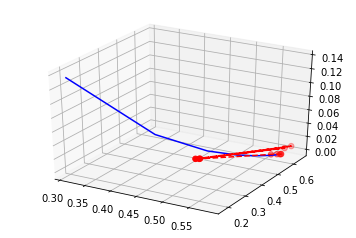

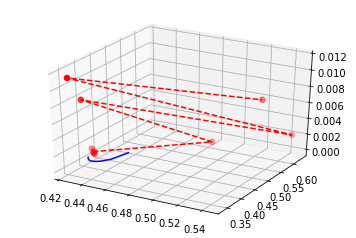

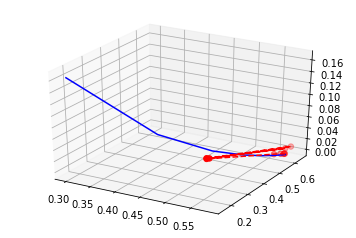

In [6]:
pred = test_vals['pred']
true = test_vals['true']
plot_sample(pred, true,3)
plot_sample(pred, true,6)
plot_sample(pred, true,10)
np.save('../experiments/result/lstm_10_err.npy',test_vals)

### Visualize prediction  (TRNN with error prop)

In [18]:
import numpy as np
print( vals["loss"])
sample_id= 2
print(np.size(pred[sample_id,:,:]))
np.linalg.norm(pred[sample_id,:,:]-true[sample_id,:,:], 'fro')**2/(np.size(pred[sample_id,:,:]))

0.00467936
30


0.005421559774697945

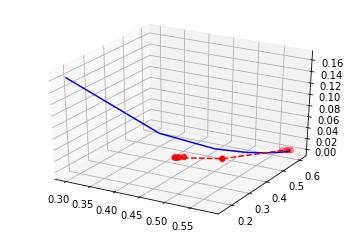

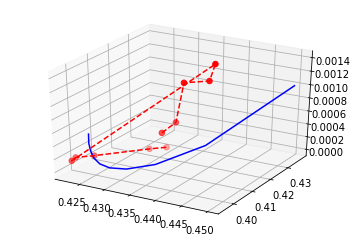

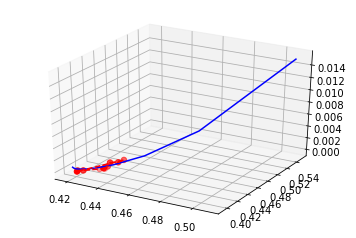

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')

pred = test_vals['pred']
true = test_vals['true']
plot_sample(pred, true,10)
plot_sample(pred, true,6)
plot_sample(pred, true,100)
# np.save('../experiments/result/trnn_10_err.npy',test_vals)